## Installation

Install the OpenFF toolkit
```
$ conda install -c conda-forge openff-toolkit
```


This will pull in two force field repos:
* [SMIRNOFF99Frosst](https://github.com/openforcefield/smirnoff99Frosst), an early experiment in porting a general force field to SMIRNOFF
* [openff-forcefields](https://github.com/openforcefield/openff-forcefields), which contains the mainline OpenFF force fields, including the "Parsley" (v1.0.0-v1.3.1) and "Sage" (v2.0.0 onwards) lines.

Install other dependencies:

```
$ conda install -c conda-forge mbuild foyer mdtraj nglview openbabel
```

## Building the our molecular system and model
We begin with some imports. We can already see a variety of packages being used: mBuild, Foyer, ParmEd, the OpenFF Toolkit, OpenMM, MDTraj, and NGLView. 

Take note of all the different data structure interconversions happening. There are *a lot*. This is good that we can get these API working together this often, but maybe not-so-good that we have to do these interconversions so often

Note: The OpenFF Toolkit also utilizes RDKit and OpenEyeToolkit. mBuild also utilizes OpenBabel

In [1]:
# MoSDeF tools for initializing and parametrizing systems
import foyer
import mbuild
# For post-simulation analysis and visualization
import mdtraj  # Also Omnia
import nglview
# ParmEd for interconverting data structures
import parmed
from mbuild.lib.molecules import Ethane
# Omnia suite of molecular modelling tools
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from simtk import openmm, unit

We will use mBuild to create a generic Ethane ($C_2H_6$) molecule. 
While this is imported from the examples, mBuild functionality allows users to construct chemical systems in a lego-like fashion by declaring particles and bonding them. 
Under the hood, rigid transformations are performed to orient particles-to-be-bonded

In [2]:
mbuild_compound = Ethane()
mbuild_compound.visualize(backend="nglview")

NGLWidget()

Another operation we can do within mBuild is to take this compound, convert it to an `openbabel.Molecule` object,
and obtain the SMILES string for it. If Open Babel doesn't work, run `smiles_string = "CC"` and continue.

In [ ]:
ethane_obmol = mbuild_compound.to_pybel()
ethane_obmol.write("smi", "out.smi", overwrite=True)
smiles_file = open("out.smi")
print(smiles_file.readlines()[0].split()[0])

SMILES strings are a common molecule representation and the starting point for many cheminformatics workflows. The OpenFF toolkit provides interfaces to two toolkits: The RDKit and OpenEye toolkits. OpenEye toolkits are free for academic use but require a license, so let's just use RDKit here.

In [4]:
openff_mol = Molecule.from_smiles(smiles_string)
type(openff_mol)

openff.toolkit.topology.molecule.Molecule

The default representation in Jupyter notebooks is a 2-D depiction of the chemical graph.

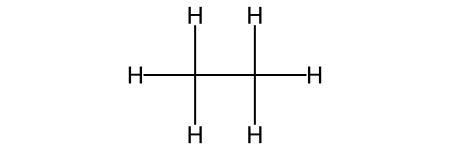

In [5]:
openff_mol.visualize()

However, we can use the OpenFF Toolkit to turn this into a 3-D model. A conformer is simply a single set of 3-D coordinates for a molecule. Many applications involve generating tens or hundreds of conformers; here, let's just generate one conformer and visualize it. (Note that interactive 3-D visualization requires NGLView and therefore won't work if NGLView is not installed or does not work well on your computer.)

In [6]:
openff_mol.generate_conformers(n_conformers=1)
print(openff_mol.conformers[0].value_in_unit(unit.angstrom))
openff_mol.visualize(
    backend="nglview"
)  # Change to "rdkit" for a simpler representation

[[ 8.15113187e-01 -5.38336337e-01  4.92812693e-01]
 [ 2.15479708e+00 -5.16308993e-02 -1.16608376e-02]
 [ 1.35660172e-04  7.38382339e-04  5.88506460e-04]
 [ 6.93132877e-01 -1.60666096e+00  2.90616542e-01]
 [ 7.30285406e-01 -3.80015731e-01  1.57207322e+00]
 [ 2.96979499e+00 -5.90627909e-01  4.80488449e-01]
 [ 2.27674198e+00  1.01656127e+00  1.90807253e-01]
 [ 2.23959613e+00 -2.09655568e-01 -1.09094548e+00]]


NGLWidget()

We can convert an `mbuild.Compound` object to a `parmed.Structure`, which includes a `openmm.Topology` object as its `.topology` attribute.
`openmm.Topology` objects don't actually know positions, they just know certain atomic and bonding information, but no coordinates/velocities/force field information. We can store the positions separately.

In [7]:
openmm_topology = mbuild_compound.to_parmed().topology
positions = mbuild_compound.xyz
print(openmm_topology)
print(positions)

<Topology; 1 chains, 1 residues, 8 atoms, 7 bonds>
[[ 2.81966699e-17 -1.40000000e-01 -1.46442715e-17]
 [-1.06999993e-01 -1.40000000e-01 -6.27354160e-18]
 [ 3.57000083e-02 -2.16900005e-01  6.53000027e-02]
 [ 3.57000083e-02 -1.58100008e-01 -9.92999971e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.06999993e-01  0.00000000e+00  0.00000000e+00]
 [-3.57000083e-02  7.69000053e-02  6.53000027e-02]
 [-3.57000083e-02  1.81000084e-02 -9.92999971e-02]]


To translate these objects into `openff.toolkit.topology.Topology` objects, we need to identify the unique molecules, which helps identify the isolated subgraphs - individual molecules that don't bond to anything outside its molecular network. For more see the corresponding [documentation](https://open-forcefield-toolkit.readthedocs.io/en/latest/api/generated/openff.toolkit.topology.Topology.html#openff.toolkit.topology.Topology.from_openmm) page.

Using the SMILES string, we can generate an `openff.toolkit.topology.Molecule` object, which is this self-enclosed bonding entity (chemically speaking, this is a molecule)

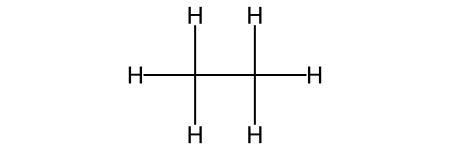

In [8]:
ethane_molecule = Molecule.from_smiles(smiles_string)
ethane_molecule

Now that we have isolated the unique molecules, we can construct our `openff.toolkit.topology.Topology` object from our `openmm.Topology` and `openff.toolkit.topology.Molecule` objects.

In [10]:
openff_topology = Topology.from_openmm(
    openmm_topology, unique_molecules=[ethane_molecule]
)
openff_topology

## Adding in a force field, evaluating energy

Next, we need to create our `ForceField` object. These are encoded on disk in `.offxml` files and available by default with installations of the OpenFF Toolkit via the `entry_points` mechanism. Here, we'll load the latest release, version 2.0.0 codename "Sage." For more, see the table in the README of the [`openff-forcefields`](https://github.com/openforcefield/openff-forcefields) repo.

In [11]:
sage = ForceField("openff-2.0.0.offxml")
sage

With the `Topology` and `Forcefield` objects, we can create an `openmm.System`. 
Note the discrepancy/interplay between the objects - `openff` objects are the molecular mechanics building blocks, but `openmm` is ultimately the workhorse for simulating and representing these systems (although you could opt to simulate with other engines via `parmed` and other tools).

Note the use of AM1-BCC methods to identify partial charges.

In [12]:
openmm_system = sage.create_openmm_system(openff_topology)
openmm_system

<openmm.openmm.System; proxy of <Swig Object of type 'OpenMM::System *' at 0x14ffa2f30> >

This is a utility function we will use to evaluate the energy of a molecular system.
Given an `openmm.System` (force field, parameters, topological, atomic information) and atomic coordinates, we can get a potential energy associated with that set of coordinatess

In [13]:
def get_energy(system, positions):
    """
    Return the potential energy.

    Parameters
    ----------
    system : simtk.openmm.System
        The system to check
    positions : simtk.unit.Quantity of dimension (natoms,3) with units of length
        The positions to use
    Returns
    ---------
    energy

    Notes
    -----
    Taken from an openforcefield notebook
    """

    integrator = openmm.VerletIntegrator(1.0 * unit.femtoseconds)
    context = openmm.Context(system, integrator)
    context.setPositions(positions)
    state = context.getState(getEnergy=True)
    energy = state.getPotentialEnergy().in_units_of(unit.kilocalories_per_mole)
    return energy

Next, we will try to calculate the potential energy of our ethane system under the SMIRNOFF force field.
As a (small) obstacle to doing this, we need to change the dimensions of our simulation box because some force fields and simulations use cutoffs, and cutoffs cannot be larger than the simulation box itself.

Okay 45 kcal/mol, cool. Potential energies of single configurations are usually not helpful for any real physical analysis, but can be helpful in comparing force fields.

In [14]:
import numpy as np

box_vectors = np.eye(3) * 10 * unit.nanometer

openmm_system.setDefaultPeriodicBoxVectors(*box_vectors)
get_energy(openmm_system, positions)

Quantity(value=55.69414541020257, unit=kilocalorie/mole)

## Tangent: Interfacing with other simulation engines
We can use `parmed` to convert the `openmm.Topology`, `openmm.System`, and coordinates into a `parmed.Structure`.
From a `parmed.Structure`, we can spit out files appropriate for different simulation packages. 
Word of caution, while the developers of `parmed` did an excellent job building the conversion tools, please do your due diligence to make sure the output is as you expect

In [15]:
pmd_structure = parmed.openmm.load_topology(
    openmm_topology, system=openmm_system, xyz=positions
)
pmd_structure

<Structure 8 atoms; 1 residues; 7 bonds; PBC (orthogonal); NOT parametrized>

## Comparing to the OPLS-AA force field
Let's use a different force field. 
`foyer` ships with an XML of the OPLS-AA force field.
We will use `foyer` (which utilizes some `parmed` and `openmm` api) to build our molecular model of ethane with OPLS

* Create the `foyer.Forcefield` object
* Apply it to our `mbuild.Compound`, get a `parmed.Structure`
* Convert the `parmed.Structure` to an `openmm.System`
* Reset the box vectors to be consistent with the SMIRNOFF example
* Evaluate the energy

In [16]:
foyer_ff = foyer.Forcefield(name="oplsaa")
oplsaa_structure = foyer_ff.apply(mbuild_compound)
oplsaa_system = oplsaa_structure.createSystem()
oplsaa_system.setDefaultPeriodicBoxVectors(*box_vectors)
get_energy(oplsaa_system, oplsaa_structure.positions)

/Users/mwt/miniconda3/envs/openff-system/lib/python3.9/site-packages/foyer/validator.py:165: ValidationWarning: You have empty smart definition(s)
  warn("You have empty smart definition(s)", ValidationWarning)
/Users/mwt/miniconda3/envs/openff-system/lib/python3.9/site-packages/foyer/forcefield.py:348: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 8, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)


Quantity(value=37.52734328319192, unit=kilocalorie/mole)

37.5 kcal/mol versus 45.0 kcal/mol, for a *single* ethane. This is a little alarming because this energetic difference stems from how the interactions are quantified and parametrized. 

However, this isn't a deal-breaker since most physically-interesting phenomena depend on changes in (free) energies. So a singular energy isn't important - how it varies when you change configurations or sample configurational space is generally more important

## Cracking open the models and looking at parameters

In this whole process, we've been dealing with data structures and API that are fairly transparent. 
What's great now is that we can look in-depth at these data structures. 
Specifically, we could look at the force field parameters, either within the force field files or molecular models themselves.

We're going to crack open these `openmm.System` objects, looking at how some of these forces are parametrized

Within the SMIRNOFF force field applied to ethane, we have some harmonic bonds, harmonic angles, periodic torsions, and nonbonded forces

In [17]:
sage_system = openmm_system  # Renaming from earlier
sage_system.getForces()

[<openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x14ff3d600> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x1506864b0> >,
 <openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x15066ecc0> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x15066ecf0> >]

Within the OPLS force field applied to ethane, we have some harmonic bonds, harmonic angles, Ryckaert-Belleman torsions, and nonbonded forces. 
Don't worry about the center of mass motion remover - that's more for running a simulation.

In [18]:
oplsaa_system.getForces()

[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x14ffa1ba0> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x15066eb10> >,
 <openmm.openmm.RBTorsionForce; proxy of <Swig Object of type 'OpenMM::RBTorsionForce *' at 0x15066ef30> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x15066eea0> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x1507da630> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x15068a210> >]

We are going to compare the *nonbonded parameters* between these `openmm.System` objects. 
For every particle in our system, we're going to look at their charges, LJ sigmas, and LJ epsilsons (both of these systems utilize Coulombic electrostatics and Lennard-Jones potentials)

Based on the charges and frequency-of-appearance, we can see which ones are carbons and which ones are hydrogens. 

The OPLS-system is more-charged, carbons are more negative and hydrogens are more positive. 
The SMIRNOFF-system actually isn't electro-neutral, and that might be consequence of having used AM1-BCC for such a small system.

The sigmas are pretty similar between FF implementations. The hydrogen epsilsons in SMIRNOFF are about half of those in OPLS. The carbon epsilons in SMIRNOFF are almost double those in OPLS. This is kind of interesting, while SMIRNOFF-ethane has weaker electrostatics (weaker charges), the LJ might compensate with the greater carbon-epsilon.

In [19]:
oplsaa_nonbondedforce = [
    f for f in oplsaa_system.getForces() if type(f) == openmm.NonbondedForce
][0]
sage_nonbondedforce = [
    f for f in sage_system.getForces() if type(f) == openmm.NonbondedForce
][0]
for i in range(oplsaa_nonbondedforce.getNumParticles()):
    opls_params = oplsaa_nonbondedforce.getParticleParameters(i)
    sage_params = sage_nonbondedforce.getParticleParameters(i)
    print(opls_params)
    print(sage_params)
    print("---")

[Quantity(value=-0.18, unit=elementary charge), Quantity(value=0.5, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[Quantity(value=-0.09384000208228827, unit=elementary charge), Quantity(value=0.3379531761626621, unit=nanometer), Quantity(value=0.45538911611061844, unit=kilojoule/mole)]
---
[Quantity(value=0.06, unit=elementary charge), Quantity(value=0.5, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[Quantity(value=0.03128000069409609, unit=elementary charge), Quantity(value=0.2644543413268125, unit=nanometer), Quantity(value=0.06602135607582665, unit=kilojoule/mole)]
---
[Quantity(value=0.06, unit=elementary charge), Quantity(value=0.5, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[Quantity(value=0.03128000069409609, unit=elementary charge), Quantity(value=0.2644543413268125, unit=nanometer), Quantity(value=0.06602135607582665, unit=kilojoule/mole)]
---
[Quantity(value=0.06, unit=elementary charge), Quantity(value=0.5, unit=nanometer), Quantity

## Running some molecular dynamics simulations
We've come this far in building our model with different force fields, we might as well build up the rest of the simulation.

`openmm` will be used to run our simulation, since we already have an `openmm.System` object. 
We need an integrator that describes our equations of motion, timestep, and temperature behavior.

As a side note, we forcibly made our simulation box really big to address cutoffs, but we can probably go with a smaller box that still fits the bill. The smaller box helps speed up the computation.

In [20]:
integrator = openmm.LangevinIntegrator(
    323 * unit.kelvin, 1.0 / unit.picoseconds, 0.001 * unit.picoseconds
)
small_box_vectors = box_vectors * 0.2
sage_system.setDefaultPeriodicBoxVectors(*small_box_vectors)

We combine our `openmm.Topology`, `openmm.System`, and `openmm.Integrator` to make our `openmm.Simulation`, then set the positions

In [21]:
sage_simulation = openmm.app.Simulation(openmm_topology, sage_system, integrator)
sage_simulation.context.setPositions(positions)

Before running the simulation, we need to report some information.
Otherwise, the simulation's going to run and we won't have anything to show for it.
This is handled in `openmm` by creating `openmmm.reporters` and attaching them to your `openmm.Simulation`
We will write out the timeseries of coordinates (trajectory) in a `dcd` format, 
but also a `pdb` format to show a singular configuration. 
In this case, we're printing a `pdb` file that corresponds to the first configuration, before any simulation was run.

In [22]:
sage_simulation.reporters.append(openmm.app.DCDReporter("trajectory.dcd", 10))
pdbreporter = openmm.app.PDBReporter("first_frame.pdb", 5000)
pdbreporter.report(sage_simulation, sage_simulation.context.getState(-1))

Now we can run our simulation!

In [23]:
sage_simulation.step(1000)

After it's finished, we can load the trajectory files into an `mdtraj.Trajectory` object, and visualize in a jupyter notebook with `nglview`. From this `mdtraj.Trajectory` object, you have pythonic-access to all the coordinates over time, and also access to various analysis libraries within `mdtraj`.

In [24]:
traj = mdtraj.load("trajectory.dcd", top="first_frame.pdb")
nglview.show_mdtraj(traj)

NGLWidget(max_frame=99)